# Audio Feature Analysis with Dimensionality Reduction

In this notebook, we will extract features (specifically, MFCCs) from our audio samples and use dimensionality reduction techniques (PCA and t-SNE) to visualize how the different classes of audio cluster together.

This will help us understand the separability of our data and identify potential challenges, such as overlapping classes, before training a machine learning model.


## 1. Install Dependencies

The cell below will install the `resampy` library, which is required by `librosa` for audio resampling. If it's already installed, this command will do nothing. Run this cell once to ensure the dependencies are met.


In [1]:
%pip install resampy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fe_de\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1. Import Libraries


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import resampy
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

sns.set_theme(style="whitegrid")


## 2. Define Paths and Load Audio Data

First, we define the base directory where our training audio files are located. We will then iterate through the subdirectories, treating each one as a distinct class.


In [3]:
BASE_AUDIO_PATH = 'Audios para Treinamento/'
classes = os.listdir(BASE_AUDIO_PATH)

print(f"Found {len(classes)} classes:")
for c in classes:
    print(f"- {c}")


Found 4 classes:
- Leak-Metal
- Leak-NonMetal
- NoLeak-Metal
- NoLeak-NonMetal


## 3. Feature Extraction

We will now write a function to process each audio file. For each file, we will:
1. Load the audio data using `librosa`.
2. Extract Mel-Frequency Cepstral Coefficients (MFCCs).
3. To ensure consistency, we will use the *mean* of the MFCCs across the time axis. This gives us a single feature vector for each audio file.


In [4]:
def extract_features(file_path, n_mfcc=20):
    """Extracts the mean of MFCCs from an audio file."""
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        return mfccs_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Loop through all files and extract features
all_features = []
all_labels = []

for label in classes:
    class_path = os.path.join(BASE_AUDIO_PATH, label)
    files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    
    print(f'\nProcessing class: {label}')
    for file_name in tqdm(files):
        file_path = os.path.join(class_path, file_name)
        features = extract_features(file_path)
        if features is not None:
            all_features.append(features)
            all_labels.append(label)

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)

print(f"\nExtracted features from {X.shape[0]} files.")



Processing class: Leak-Metal


100%|██████████| 15/15 [00:01<00:00,  9.05it/s]



Processing class: Leak-NonMetal


100%|██████████| 15/15 [00:00<00:00, 28.40it/s]



Processing class: NoLeak-Metal


100%|██████████| 15/15 [00:00<00:00, 27.68it/s]



Processing class: NoLeak-NonMetal


100%|██████████| 15/15 [00:00<00:00, 22.61it/s]


Extracted features from 60 files.


## 4. Data Scaling

Dimensionality reduction algorithms are sensitive to the scale of the features. We'll use `StandardScaler` to normalize our feature set.


In [5]:
# Only proceed if features have been extracted
if X.shape[0] > 0:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"Successfully scaled {X_scaled.shape[0]} samples.")
else:
    print("No features were extracted. Skipping scaling and visualization.")
    X_scaled = np.array([])


Successfully scaled 60 samples.


## 5. PCA Visualization

Principal Component Analysis (PCA) is a linear dimensionality reduction technique. It's fast and provides a good baseline for how our data is structured.


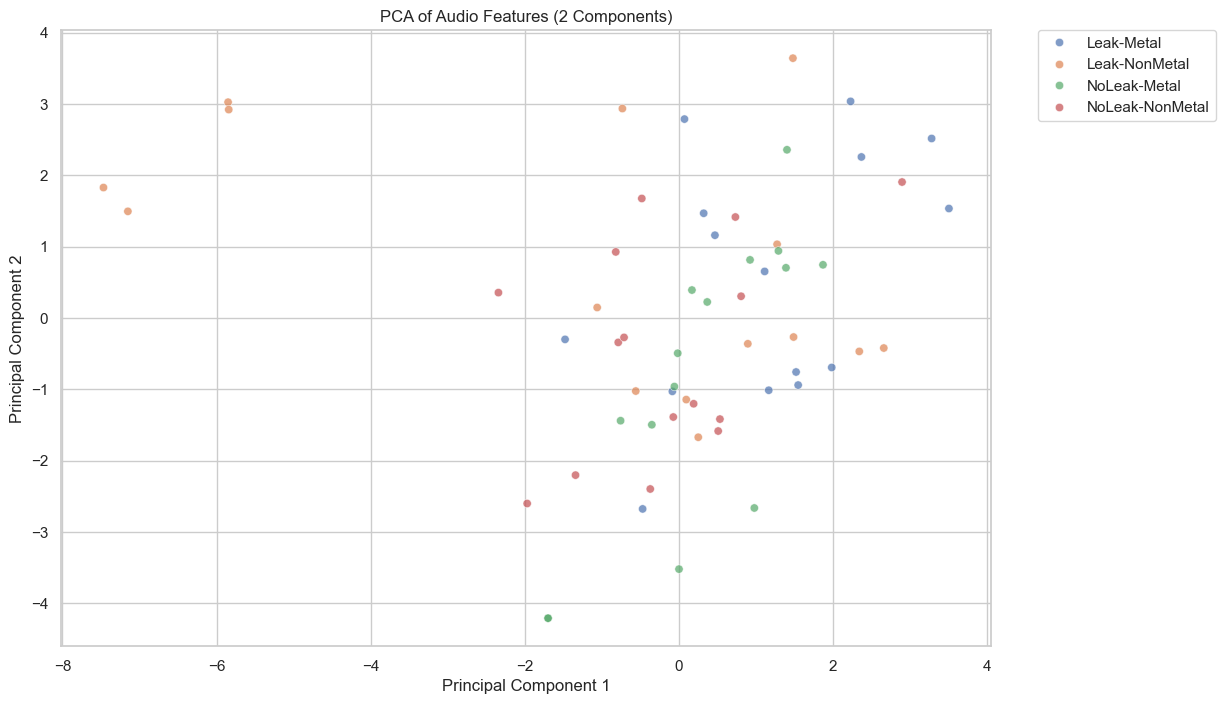

In [6]:
if X_scaled.shape[0] > 0:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
    pca_df['Class'] = y
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="Principal Component 1", y="Principal Component 2",
        hue="Class",
        data=pca_df,
        palette="deep",
        alpha=0.7
    )
    plt.title('PCA of Audio Features (2 Components)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("Skipping PCA: No data to visualize.")


## 6. t-SNE Visualization

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique that is particularly good at visualizing high-dimensional data. It tries to preserve local similarities in the data, often revealing clearer clusters than PCA.


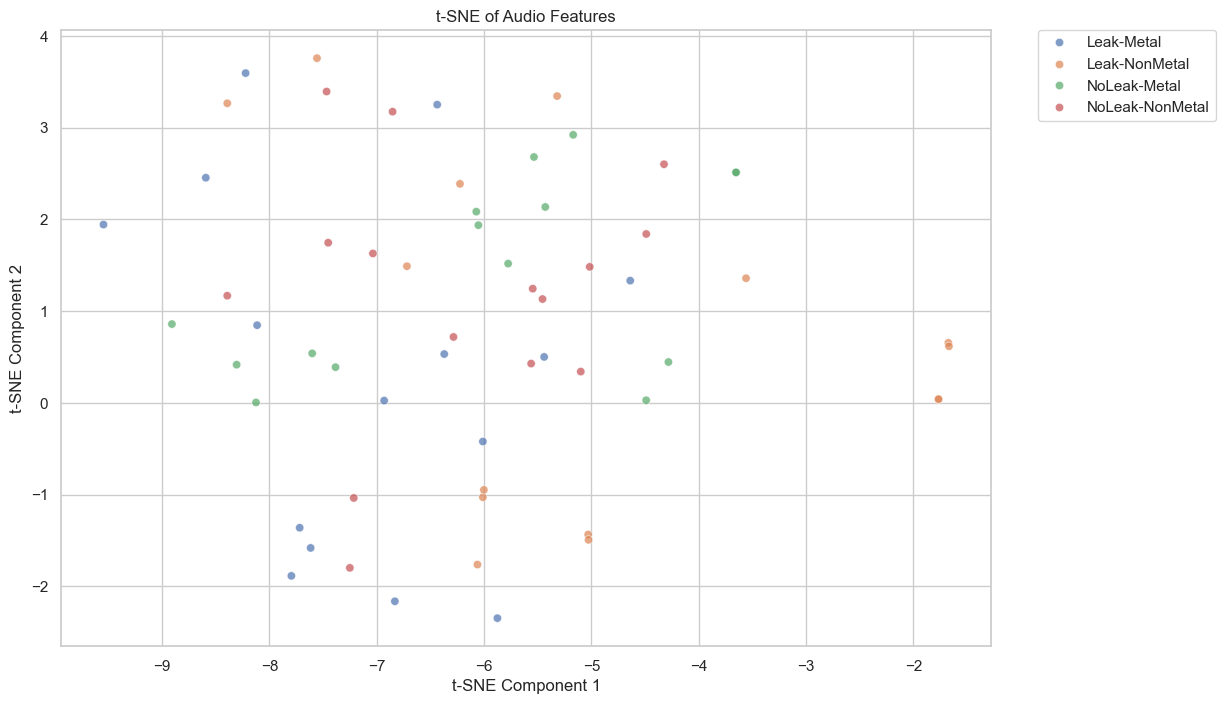

In [8]:
if X_scaled.shape[0] > 0:
    # It's a good practice to run t-SNE on PCA-reduced data to speed up computation and reduce noise
    # Let's first run PCA with a higher number of components.
    # Note: n_components must be less than n_features (20 in our case). We'll use 15.
    pca_for_tsne = PCA(n_components=15)
    X_pca_for_tsne = pca_for_tsne.fit_transform(X_scaled)

    # Perplexity for t-SNE must be less than the number of samples.
    tsne_perplexity = min(30, X_scaled.shape[0] - 1)
    
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, max_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_pca_for_tsne) # Use the PCA-reduced data
    
    tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])
    tsne_df['Class'] = y
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="t-SNE Component 1", y="t-SNE Component 2",
        hue="Class",
        data=tsne_df,
        palette="deep",
        alpha=0.7
    )
    plt.title('t-SNE of Audio Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("Skipping t-SNE: No data to visualize.")


## 7. Analysis and Interpretation

*(This section is for you to fill in after running the notebook.)*

- **How distinct are the clusters?** Do the `Leak` and `NoLeak` classes form separate groups?
- **Are there any outliers?** Are there any points that are far from their designated class cluster?
- **Where do the different types of leaks (`Leak-Metal` vs. `Leak-NonMetal`) and no-leaks (`NoLeak-Metal` vs. `NoLeak-NonMetal`) appear?** Do they mix together or form sub-clusters?
- **Based on these plots, how confident are we that a machine learning model can learn to separate these classes?**


A single mean whas not enough, we need to go deeper